In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**shift(0,30,60,90,120,150,180,210,240,270,300,330,360)**

In [2]:
df = pd.read_csv("UK_research2.csv", encoding="utf-8").drop(columns="Unnamed: 0")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
#df[['Headline', 'gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']] = df[['Headline', 'gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']].shift(30)
df = df.dropna().reset_index(drop=True)
df

,Date,Headline,gold,oil,bond,cad,cny,eur,jpy,usd,ETF
0,2014-01-02,China-Japan tensions: Chef crashes balloon nea...,743.80,58.01,11.13,1.76,10.01,1.20,174.59,1.66,15372.90
1,2014-01-03,'What's normal at your work that would blow an...,753.42,57.40,11.16,1.75,9.94,1.20,172.40,1.64,15428.82
2,2014-01-04,'What's normal at your work that would blow an...,753.42,57.40,11.16,1.75,9.94,1.20,172.40,1.64,15428.82
3,2014-01-05,Outrage over commercialisation plans for BBC W...,752.17,57.39,11.16,1.75,9.94,1.20,172.40,1.64,15428.82
4,2014-01-06,Shia LaBeouf copies rapper Gucci Mane and feud...,754.10,57.07,11.19,1.74,9.91,1.21,172.14,1.64,15503.45
...,...,...,...,...,...,...,...,...,...,...,...
3281,2022-12-27,When should I take down my Christmas tree and ...,1507.11,66.31,10.51,1.64,8.42,1.14,160.40,1.21,18359.19
3282,2022-12-28,The One With.... Every Friends episode ranked ...,1501.22,65.34,10.48,1.63,8.36,1.13,160.52,1.20,18472.29
3283,2022-12-29,Boxing Day sales 2022 – live: The best deals t...,1505.73,65.21,10.48,1.64,8.38,1.13,161.20,1.20,18491.61
3284,2022-12-30,9 sex scenes the actors are mortified about Co...,1508.17,66.51,10.49,1.63,8.39,1.13,160.23,1.21,18314.14


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']] = scaler.fit_transform(df[['gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']])
df

,Date,Headline,gold,oil,bond,cad,cny,eur,jpy,usd,ETF
0,2014-01-02,China-Japan tensions: Chef crashes balloon nea...,-1.295076,0.826245,-1.864866,0.121086,1.782118,0.109861,1.224642,2.128259,15372.90
1,2014-01-03,'What's normal at your work that would blow an...,-1.256799,0.785739,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82
2,2014-01-04,'What's normal at your work that would blow an...,-1.256799,0.785739,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82
3,2014-01-05,Outrage over commercialisation plans for BBC W...,-1.261773,0.785075,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82
4,2014-01-06,Shia LaBeouf copies rapper Gucci Mane and feud...,-1.254094,0.763826,-1.807392,-0.056305,1.605175,0.230356,1.077339,1.981330,15503.45
...,...,...,...,...,...,...,...,...,...,...,...
3281,2022-12-27,When should I take down my Christmas tree and ...,1.742005,1.377392,-2.458758,-0.943265,-1.031278,-0.613110,0.371488,-1.177646,18359.19
3282,2022-12-28,The One With.... Every Friends episode ranked ...,1.718570,1.312981,-2.487495,-1.031961,-1.137444,-0.733606,0.378703,-1.251111,18472.29
3283,2022-12-29,Boxing Day sales 2022 – live: The best deals t...,1.736514,1.304348,-2.487495,-0.943265,-1.102055,-0.733606,0.419587,-1.251111,18491.61
3284,2022-12-30,9 sex scenes the actors are mortified about Co...,1.746223,1.390672,-2.477916,-1.031961,-1.084361,-0.733606,0.361267,-1.177646,18314.14


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3286 non-null   datetime64[ns]
 1   Headline  3286 non-null   object        
 2   gold      3286 non-null   float64       
 3   oil       3286 non-null   float64       
 4   bond      3286 non-null   float64       
 5   cad       3286 non-null   float64       
 6   cny       3286 non-null   float64       
 7   eur       3286 non-null   float64       
 8   jpy       3286 non-null   float64       
 9   usd       3286 non-null   float64       
 10  ETF       3286 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 282.5+ KB


In [5]:
df.describe()

,Date,gold,oil,bond,cad,cny,eur,jpy,usd,ETF
count,3286,3.286000e+03,3.286000e+03,3.286000e+03,3.286000e+03,3.286000e+03,3.286000e+03,3.286000e+03,3.286000e+03,3286.000000
mean,2018-07-02 11:59:59.999999744,-6.227520e-16,3.113760e-16,-2.767787e-16,-6.919467e-17,-1.107115e-15,9.687253e-16,-1.245504e-15,1.522283e-15,16089.787572
min,2014-01-02 00:00:00,-1.486060e+00,-3.025806e+00,-3.368756e+00,-2.451096e+00,-2.712238e+00,-1.577073e+00,-1.699167e+00,-2.206150e+00,10259.170000
25%,2016-04-02 06:00:00,-8.168601e-01,-6.975429e-01,-6.291855e-01,-5.884811e-01,-6.066144e-01,-7.336057e-01,-7.714605e-01,-6.633944e-01,14547.282500
50%,2018-07-02 12:00:00,-3.072715e-01,-1.488863e-01,4.133859e-02,-2.336973e-01,-2.881168e-01,-2.516246e-01,-2.363608e-01,-2.960716e-01,15884.150000
75%,2020-09-30 18:00:00,9.441701e-01,5.046874e-01,7.310205e-01,4.758702e-01,4.904329e-01,2.303564e-01,7.376409e-01,5.120386e-01,17342.132500
max,2022-12-31 00:00:00,2.013043e+00,3.583971e+00,1.995437e+00,3.048052e+00,2.914554e+00,3.001748e+00,2.496255e+00,2.569046e+00,21790.560000
std,NaN,1.000152e+00,1.000152e+00,1.000152e+00,1.000152e+00,1.000152e+00,1.000152e+00,1.000152e+00,1.000152e+00,2077.210206


In [4]:
stopwords_object = stopwords.words('english')
df["Headline"] = df["Headline"].str.lower()

def preprocessing_text(data):
    if type(data) is float:
      data = str(data);

    data = re.sub("[^a-zA-Z]"," ", data)

    tokens = word_tokenize(data)
    word_tokens = [w for w in tokens if w not in stopwords_object]


    stemmer = PorterStemmer()
    stem_words = [stemmer.stem(w) for w in word_tokens]


    lemmer = WordNetLemmatizer()
    lem_words = [lemmer.lemmatize(w) for w in stem_words]

    return " ".join(lem_words)

In [7]:
df["Headline2"] = df["Headline"].apply(preprocessing_text)
df

,Date,Headline,gold,oil,bond,cad,cny,eur,jpy,usd,ETF,Headline2
0,2014-01-02,china-japan tensions: chef crashes balloon nea...,-1.295076,0.826245,-1.864866,0.121086,1.782118,0.109861,1.224642,2.128259,15372.90,china japan tension chef crash balloon near di...
1,2014-01-03,'what's normal at your work that would blow an...,-1.256799,0.785739,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82,normal work would blow anyon el mind cuban all...
2,2014-01-04,'what's normal at your work that would blow an...,-1.256799,0.785739,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82,normal work would blow anyon el mind outrag co...
3,2014-01-05,outrage over commercialisation plans for bbc w...,-1.261773,0.785075,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82,outrag commercialis plan bbc world servic dead...
4,2014-01-06,shia labeouf copies rapper gucci mane and feud...,-1.254094,0.763826,-1.807392,-0.056305,1.605175,0.230356,1.077339,1.981330,15503.45,shia labeouf copi rapper gucci mane feud lena ...
...,...,...,...,...,...,...,...,...,...,...,...,...
3281,2022-12-27,when should i take down my christmas tree and ...,1.742005,1.377392,-2.458758,-0.943265,-1.031278,-0.613110,0.371488,-1.177646,18359.19,take christma tree decor new year eve lyric au...
3282,2022-12-28,the one with.... every friends episode ranked ...,1.718570,1.312981,-2.487495,-1.031961,-1.137444,-0.733606,0.378703,-1.251111,18472.29,one everi friend episod rank worst best amazon...
3283,2022-12-29,boxing day sales 2022 – live: the best deals t...,1.736514,1.304348,-2.487495,-0.943265,-1.102055,-0.733606,0.419587,-1.251111,18491.61,box day sale live best deal shop dyson john le...
3284,2022-12-30,9 sex scenes the actors are mortified about co...,1.746223,1.390672,-2.477916,-1.031961,-1.084361,-0.733606,0.361267,-1.177646,18314.14,sex scene actor mortifi comet last visibl ice ...


## **TF-IDF**

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [9]:
tfidf_result = tfidf.fit_transform(df["Headline2"])
df["tfidf_Headline"] = list(tfidf_result.toarray())

In [10]:
df["tfidf_Headline"] = np.array(df['tfidf_Headline'].tolist())
X = df[['tfidf_Headline', 'gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']]
y = df["ETF"].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

### **Random Forest**

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train)

rf_predictions = rf.predict(X_test)

rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
print(f"Random Forest RMSE: {rf_rmse}")

rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f"Random Forest MAE: {rf_mae}")

rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
print(f"Random Forest MAPE: {rf_mape}")

r2 = r2_score(y_test, rf_predictions)
print(f'Random Forest R제곱: {r2}')

Random Forest RMSE: 258.21879497824153
Random Forest MAE: 131.44716263544237
Random Forest MAPE: 0.008258576142310282
Random Forest R제곱: 0.9838733511845783


In [12]:
feature_importances = rf.feature_importances_

for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

tfidf_Headline: 0.00029920739468099406
gold: 0.31771247567416305
oil: 0.45786518070375626
bond: 0.031205773942867193
cad: 0.01020530138123627
cny: 0.034692738915032724
eur: 0.02521616446279618
jpy: 0.03593158021813145
usd: 0.08687157730733595


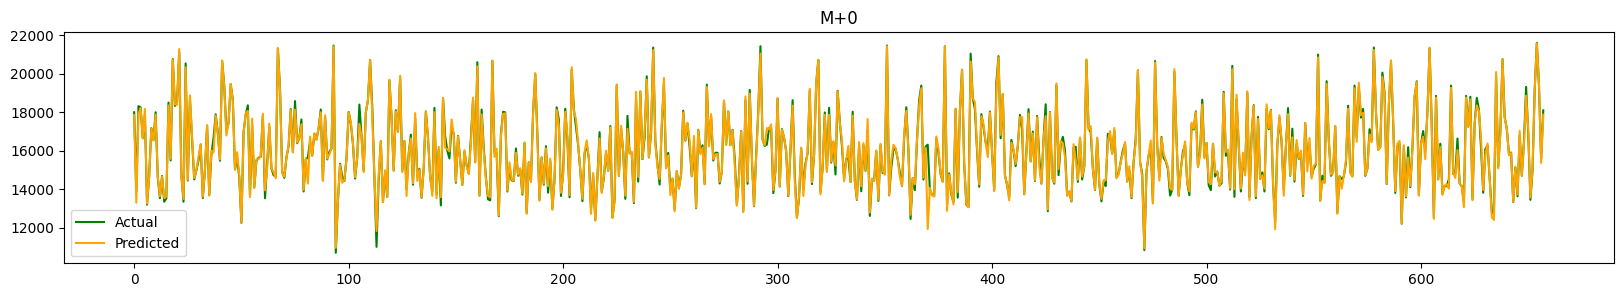

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))
plt.plot(y_test, label='Actual', color='green')
plt.plot(rf_predictions, label='Predicted', color='orange', linestyle='-')
plt.title('M+0')
plt.legend()
plt.show()

### **LSTM**

In [14]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import PReLU

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


X_lstm_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
y_lstm_train = np.reshape(y_train, (y_train.shape[0], 1))

X_lstm_val = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))
y_lstm_val = np.reshape(y_val, (y_val.shape[0], 1))

X_lstm_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
y_lstm_test = np.reshape(y_test, (y_test.shape[0], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(784, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
#lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(256))
lstm_model.add(PReLU())
#lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(64))
lstm_model.add(PReLU())
lstm_model.add(Dense(1, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

In [15]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 784)               2464896   
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 p_re_lu (PReLU)             (None, 256)               256       
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 p_re_lu_1 (PReLU)           (None, 64)                64        
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2682689 (10.23 MB)
Trainable params: 26826

In [16]:
history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=300, batch_size=32,
                         validation_data=(X_lstm_val, y_lstm_val),verbose=1)

lstm_predictions = lstm_model.predict(X_lstm_test)

lstm_rmse = mean_squared_error(y_lstm_test, lstm_predictions, squared=False)
print(f"LSTM RMSE: {lstm_rmse}")

lstm_mae = mean_absolute_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAE: {lstm_mae}")

lstm_mape = mean_absolute_percentage_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAPE: {lstm_mape}")

r2 = r2_score(y_lstm_test, lstm_predictions)
print(f'LSTM R제곱: {r2}')

Epoch 1/300
83/83 [==============================] - 7s 57ms/step - loss: 214487760.0000 - mape: 88.9874 - val_loss: 74286896.0000 - val_mape: 51.5498
Epoch 2/300
83/83 [==============================] - 4s 50ms/step - loss: 12541906.0000 - mape: 16.3833 - val_loss: 4362479.0000 - val_mape: 10.7035
Epoch 3/300
83/83 [==============================] - 4s 51ms/step - loss: 4364637.0000 - mape: 10.5037 - val_loss: 4415715.5000 - val_mape: 10.9688
Epoch 4/300
83/83 [==============================] - 4s 51ms/step - loss: 4364548.5000 - mape: 10.5030 - val_loss: 4450534.5000 - val_mape: 11.0793
Epoch 5/300
83/83 [==============================] - 4s 50ms/step - loss: 4376368.5000 - mape: 10.4932 - val_loss: 4430173.5000 - val_mape: 11.0168
Epoch 6/300
83/83 [==============================] - 4s 51ms/step - loss: 4387938.0000 - mape: 10.5625 - val_loss: 4367897.0000 - val_mape: 10.7543
Epoch 7/300
83/83 [==============================] - 4s 51ms/step - loss: 4388610.0000 - mape: 10.5395 - val

## **Hybrid**

In [17]:
X = df[['gold', 'oil', 'cny', 'jpy', 'usd']]
y = df["ETF"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


X_lstm_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
y_lstm_train = np.reshape(y_train, (y_train.shape[0], 1))

X_lstm_val = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))
y_lstm_val = np.reshape(y_val, (y_val.shape[0], 1))

X_lstm_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
y_lstm_test = np.reshape(y_test, (y_test.shape[0], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(784, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
#lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(256))
lstm_model.add(PReLU())
#lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(64))
lstm_model.add(PReLU())
lstm_model.add(Dense(1, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=300, batch_size=32,
                         validation_data=(X_lstm_val, y_lstm_val),verbose=1)

lstm_predictions = lstm_model.predict(X_lstm_test)

lstm_rmse = mean_squared_error(y_lstm_test, lstm_predictions, squared=False)
print(f"LSTM RMSE: {lstm_rmse}")

lstm_mae = mean_absolute_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAE: {lstm_mae}")

lstm_mape = mean_absolute_percentage_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAPE: {lstm_mape}")

r2 = r2_score(y_lstm_test, lstm_predictions)
print(f'LSTM R제곱: {r2}')

Epoch 1/300
83/83 [==============================] - 5s 38ms/step - loss: 227953312.0000 - mape: 92.3093 - val_loss: 113312912.0000 - val_mape: 64.9888
Epoch 2/300
83/83 [==============================] - 3s 32ms/step - loss: 22375800.0000 - mape: 20.9102 - val_loss: 3638587.2500 - val_mape: 9.5006
Epoch 3/300
83/83 [==============================] - 3s 33ms/step - loss: 3391167.0000 - mape: 9.0814 - val_loss: 3597540.7500 - val_mape: 9.4706
Epoch 4/300
83/83 [==============================] - 3s 33ms/step - loss: 3394730.2500 - mape: 9.1014 - val_loss: 3614069.5000 - val_mape: 9.4967
Epoch 5/300
83/83 [==============================] - 3s 33ms/step - loss: 3388867.2500 - mape: 9.0887 - val_loss: 3613026.5000 - val_mape: 9.4534
Epoch 6/300
83/83 [==============================] - 3s 33ms/step - loss: 3415161.5000 - mape: 9.1010 - val_loss: 3595087.0000 - val_mape: 9.4546
Epoch 7/300
83/83 [==============================] - 3s 34ms/step - loss: 3394447.5000 - mape: 9.0764 - val_loss: 36

## **BERT**

In [5]:
!pip install pandas transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

df['headline']=df["Headline"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# TEST


import torch
from torch.utils.data import DataLoader, TensorDataset

# 헤드라인 토큰화 및 패딩
tokenized_headlines = df['headline'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 256  # 최대 256 토큰으로 자르기 및 패딩
padded_headlines = [i[:max_len] + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_headlines]

attention_mask = [[float(i > 0) for i in seq] for seq in padded_headlines]

# 텐서로 변환
input_ids = torch.tensor(padded_headlines)
attention_masks = torch.tensor(attention_mask)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=32)

bert_embeddings = []

model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_masks = batch
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        # [CLS] 토큰의 임베딩 수집
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        bert_embeddings.extend(cls_embeddings)

# 데이터프레임에 임베딩 저장
df['bert_headline'] = bert_embeddings

# bert_headline을 numpy 배열로 변환
df["bert_headline"] = np.array(df['bert_headline'].tolist())

# 학습 데이터를 준비
X = np.concatenate((df['bert_headline'].values.tolist(), df[['gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']].values), axis=1)
y = df["ETF"].values

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# 랜덤 포레스트 모델 학습
rf2 = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, random_state=20)
rf2.fit(X_train, y_train)

# 예측 수행
rf2_predictions = rf2.predict(X_test)

# 모델 평가
rf_rmse = mean_squared_error(y_test, rf2_predictions, squared=False)
print(f"Random Forest RMSE: {rf_rmse}")

rf_mae = mean_absolute_error(y_test, rf2_predictions)
print(f"Random Forest MAE: {rf_mae}")

rf_mape = mean_absolute_percentage_error(y_test, rf2_predictions)
print(f"Random Forest MAPE: {rf_mape}")

r2 = r2_score(y_test, rf2_predictions)
print(f'Random Forest R²: {r2}')

In [7]:
tokenized_headlines = df['headline'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [19]:
max_len = max(map(len, tokenized_headlines))
padded_headlines = torch.tensor([i + [0]*(max_len-len(i)) for i in tokenized_headlines])

In [20]:
attention_mask = (padded_headlines != 0).float()

In [21]:
with torch.no_grad():
    outputs = model(padded_headlines, attention_mask=attention_mask)

In [22]:
bert_embeddings = outputs.last_hidden_state[:, 0, :]

In [23]:
bert_embeddings.shape

torch.Size([3286, 768])

In [24]:
bert_headline = bert_embeddings.tolist()
df['bert_headline'] = bert_headline
df

,Date,Headline,gold,oil,bond,cad,cny,eur,jpy,usd,ETF,headline,bert_headline
0,2014-01-02,china-japan tensions: chef crashes balloon nea...,-1.295076,0.826245,-1.864866,0.121086,1.782118,0.109861,1.224642,2.128259,15372.90,china-japan tensions: chef crashes balloon nea...,"[-0.2510046064853668, 0.19742076098918915, 0.1..."
1,2014-01-03,'what's normal at your work that would blow an...,-1.256799,0.785739,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82,'what's normal at your work that would blow an...,"[-0.3267612159252167, 0.09422658383846283, 0.2..."
2,2014-01-04,'what's normal at your work that would blow an...,-1.256799,0.785739,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82,'what's normal at your work that would blow an...,"[-0.5226783156394958, -0.40999308228492737, 0...."
3,2014-01-05,outrage over commercialisation plans for bbc w...,-1.261773,0.785075,-1.836129,0.032390,1.658258,0.109861,1.092971,1.981330,15428.82,outrage over commercialisation plans for bbc w...,"[-0.22328640520572662, 0.12203638255596161, 0...."
4,2014-01-06,shia labeouf copies rapper gucci mane and feud...,-1.254094,0.763826,-1.807392,-0.056305,1.605175,0.230356,1.077339,1.981330,15503.45,shia labeouf copies rapper gucci mane and feud...,"[-0.16213490068912506, 0.159471333026886, 0.34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,2022-12-27,when should i take down my christmas tree and ...,1.742005,1.377392,-2.458758,-0.943265,-1.031278,-0.613110,0.371488,-1.177646,18359.19,when should i take down my christmas tree and ...,"[-0.07168658822774887, -0.11749958246946335, 0..."
3282,2022-12-28,the one with.... every friends episode ranked ...,1.718570,1.312981,-2.487495,-1.031961,-1.137444,-0.733606,0.378703,-1.251111,18472.29,the one with.... every friends episode ranked ...,"[-0.20596466958522797, -0.010855007916688919, ..."
3283,2022-12-29,boxing day sales 2022 – live: the best deals t...,1.736514,1.304348,-2.487495,-0.943265,-1.102055,-0.733606,0.419587,-1.251111,18491.61,boxing day sales 2022 – live: the best deals t...,"[-0.22203576564788818, 0.09898383170366287, 0...."
3284,2022-12-30,9 sex scenes the actors are mortified about co...,1.746223,1.390672,-2.477916,-1.031961,-1.084361,-0.733606,0.361267,-1.177646,18314.14,9 sex scenes the actors are mortified about co...,"[-0.22574925422668457, -0.043250758200883865, ..."


## **Random Forest**

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


df["bert_headline"] = np.array(df['bert_headline'].tolist())
X = df[['bert_headline', 'gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']]
y = df["ETF"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

rf2 = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, random_state=20)
rf2.fit(X_train, y_train)

rf2_predictions = rf2.predict(X_test)

rf_rmse = mean_squared_error(y_test, rf2_predictions, squared=False)
print(f"Random Forest RMSE: {rf_rmse}")

rf_mae = mean_absolute_error(y_test, rf2_predictions)
print(f"Random Forest MAE: {rf_mae}")

rf_mape = mean_absolute_percentage_error(y_test, rf2_predictions)
print(f"Random Forest MAPE: {rf_mape}")

r2 = r2_score(y_test, rf2_predictions)
print(f'Random Forest R제곱: {r2}')

Random Forest RMSE: 220.7869650182123
Random Forest MAE: 138.21190910685362
Random Forest MAPE: 0.00881617391779864
Random Forest R제곱: 0.9883803612045661


In [26]:
feature_importances = rf2.feature_importances_

for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

bert_headline: 0.0013853771772961276
gold: 0.3126299432136957
oil: 0.45826238949620024
bond: 0.029006039601860573
cad: 0.00827236212587717
cny: 0.0339779203200113
eur: 0.02735616401034312
jpy: 0.032398930811965834
usd: 0.09671087324275003


## **LSTM**

In [27]:
from keras.layers import PReLU

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

df["bert_headline"] = np.array(df['bert_headline'].tolist())
X = df[['bert_headline', 'gold', 'oil', 'bond', 'cad', 'cny', 'eur', 'jpy', 'usd']]
y = df["ETF"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_lstm_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
y_lstm_train = np.reshape(y_train, (y_train.shape[0], 1))

X_lstm_val = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))
y_lstm_val = np.reshape(y_val, (y_val.shape[0], 1))

X_lstm_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
y_lstm_test = np.reshape(y_test, (y_test.shape[0], 1))

lstm2_model = Sequential()
lstm2_model.add(LSTM(784, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
lstm2_model.add(Dense(256))
lstm2_model.add(PReLU())
lstm2_model.add(Dense(64))
lstm2_model.add(PReLU())
lstm2_model.add(Dense(1, activation='linear'))
lstm2_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

In [28]:
lstm2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 784)               2464896   
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 p_re_lu (PReLU)             (None, 256)               256       
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 p_re_lu_1 (PReLU)           (None, 64)                64        
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2682689 (10.23 MB)
Trainable params: 26826

In [29]:
history = lstm2_model.fit(X_lstm_train, y_lstm_train, epochs=300, batch_size=32,
                         validation_data=(X_lstm_val, y_lstm_val),verbose=1)

lstm_predictions = lstm2_model.predict(X_lstm_test)

lstm_rmse = mean_squared_error(y_lstm_test, lstm_predictions, squared=False)
print(f"LSTM RMSE: {lstm_rmse}")

lstm_mae = mean_absolute_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAE: {lstm_mae}")

lstm_mape = mean_absolute_percentage_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAPE: {lstm_mape}")

r2 = r2_score(y_lstm_test, lstm_predictions)
print(f'LSTM R제곱: {r2}')

Epoch 1/300
83/83 [==============================] - 5s 11ms/step - loss: 204337568.0000 - mape: 86.2602 - val_loss: 47313456.0000 - val_mape: 40.0403
Epoch 2/300
83/83 [==============================] - 0s 5ms/step - loss: 8138779.5000 - mape: 13.6263 - val_loss: 4435949.5000 - val_mape: 11.0352
Epoch 3/300
83/83 [==============================] - 0s 5ms/step - loss: 4367939.0000 - mape: 10.5458 - val_loss: 4364771.0000 - val_mape: 10.7292
Epoch 4/300
83/83 [==============================] - 0s 5ms/step - loss: 4366709.5000 - mape: 10.4902 - val_loss: 4368490.0000 - val_mape: 10.7594
Epoch 5/300
83/83 [==============================] - 0s 5ms/step - loss: 4374737.5000 - mape: 10.5125 - val_loss: 4362839.5000 - val_mape: 10.7100
Epoch 6/300
83/83 [==============================] - 0s 5ms/step - loss: 4381516.5000 - mape: 10.5342 - val_loss: 4360706.5000 - val_mape: 10.5804
Epoch 7/300
83/83 [==============================] - 0s 5ms/step - loss: 4377795.0000 - mape: 10.5040 - val_loss: 

## **Hybrid**

In [30]:
X = df[['gold', 'oil', 'cny', 'jpy', 'usd']]
y = df["ETF"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_lstm_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
y_lstm_train = np.reshape(y_train, (y_train.shape[0], 1))

X_lstm_val = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))
y_lstm_val = np.reshape(y_val, (y_val.shape[0], 1))

X_lstm_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
y_lstm_test = np.reshape(y_test, (y_test.shape[0], 1))

lstm2_model = Sequential()
lstm2_model.add(LSTM(784, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
lstm2_model.add(Dense(256))
lstm2_model.add(PReLU())
lstm2_model.add(Dense(64))
lstm2_model.add(PReLU())
lstm2_model.add(Dense(1, activation='linear'))
lstm2_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

history = lstm2_model.fit(X_lstm_train, y_lstm_train, epochs=300, batch_size=32,
                         validation_data=(X_lstm_val, y_lstm_val),verbose=1)

lstm_predictions = lstm2_model.predict(X_lstm_test)

lstm_rmse = mean_squared_error(y_lstm_test, lstm_predictions, squared=False)
print(f"LSTM RMSE: {lstm_rmse}")

lstm_mae = mean_absolute_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAE: {lstm_mae}")

lstm_mape = mean_absolute_percentage_error(y_lstm_test, lstm_predictions)
print(f"LSTM MAPE: {lstm_mape}")

r2 = r2_score(y_lstm_test, lstm_predictions)
print(f'LSTM R제곱: {r2}')

Epoch 1/300
83/83 [==============================] - 3s 11ms/step - loss: 216197584.0000 - mape: 89.3146 - val_loss: 79090656.0000 - val_mape: 53.7088
Epoch 2/300
83/83 [==============================] - 0s 5ms/step - loss: 13209740.0000 - mape: 16.4803 - val_loss: 3623957.0000 - val_mape: 9.4803
Epoch 3/300
83/83 [==============================] - 0s 5ms/step - loss: 3399503.5000 - mape: 9.0867 - val_loss: 3608383.7500 - val_mape: 9.4407
Epoch 4/300
83/83 [==============================] - 0s 5ms/step - loss: 3402567.2500 - mape: 9.0641 - val_loss: 3712526.5000 - val_mape: 9.6866
Epoch 5/300
83/83 [==============================] - 0s 5ms/step - loss: 3344448.0000 - mape: 8.9869 - val_loss: 3417919.5000 - val_mape: 9.1579
Epoch 6/300
83/83 [==============================] - 0s 5ms/step - loss: 2965915.7500 - mape: 8.4938 - val_loss: 2416533.7500 - val_mape: 8.1758
Epoch 7/300
83/83 [==============================] - 0s 5ms/step - loss: 2156540.5000 - mape: 7.5086 - val_loss: 1795895.0